In [83]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import imageio as iio
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
import re

<font size = '8'> Data Loading </font>

cat.0.jpg
cat
(374, 500, 3)


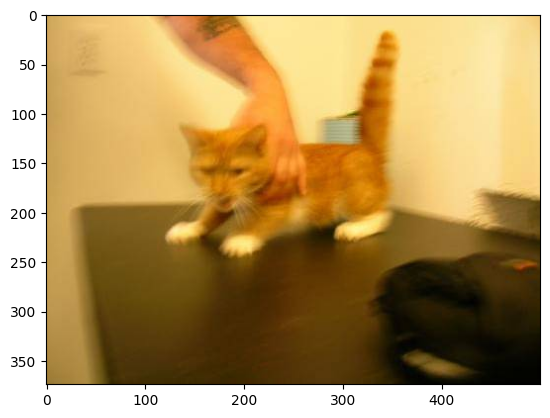

In [84]:
path = "C:\\Users\\Ahmed\\Desktop\\CatDogData\\train"
file = os.listdir(r"C:\Users\Ahmed\Desktop\CatDogData\train")
print(file[0])
print(re.sub(r"\s*\.\d+\.\w+$", "", file[0]))
img = iio.imread_v2(f"{path}\\{file[0]}")
print(img.shape)
plt.imshow(img)

In [85]:
classes = {'cat':0,
           'dog':1}

In [93]:
class MyDataset(Dataset):
    def __init__(self, dataPath, trans=None):
        super().__init__()
        self.path = dataPath
        self.files = os.listdir(self.path)
        self.trans = trans

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # our images differ in sizes, we should make them all same size
        im = iio.imread_v2(os.path.join(self.path, self.files[idx]))
        label = re.sub(r"\s*\.\d+\.\w+$", "", self.files[idx])
        label = classes[label]
        if self.trans:
            im = self.trans(im)
        #im = np.transpose(im,(1,2,0))
        return (im, label)


Text(0.5, 1.0, '0')

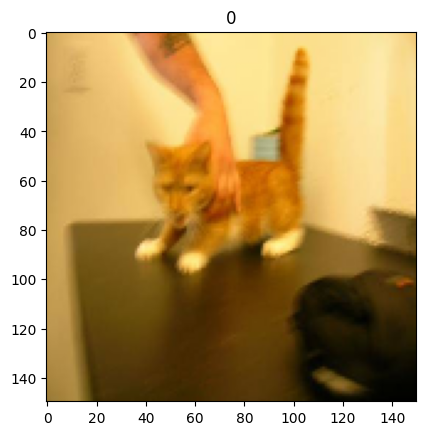

In [94]:
train = MyDataset("C:\\Users\\Ahmed\\Desktop\\CatDogData\\train", transforms.Compose([transforms.ToTensor(),transforms.Resize((150,150)) ] ) )
plt.imshow(np.transpose(train[0][0],(1,2,0)), vmin=0.0, vmax=255.0)
plt.title(train[0][1])

In [95]:
train_loader = DataLoader(train, batch_size = 64, shuffle = True)

In [96]:
tl = iter(train_loader)
batch = next(tl)
print(len(tl))
print(batch[0].shape)
print(batch[0][0].shape)
print(batch[1])

391
torch.Size([64, 3, 150, 150])
torch.Size([3, 150, 150])
tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0])


torch.Size([64, 3, 150, 150])


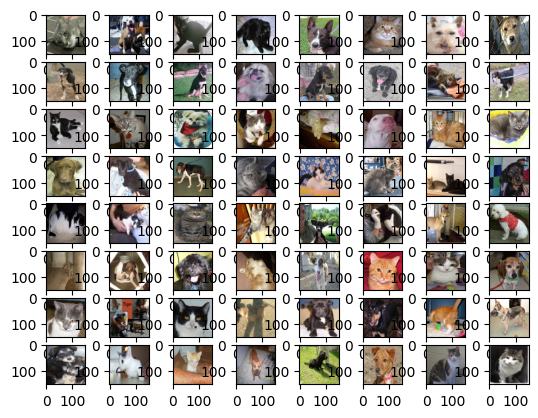

In [97]:
print(batch[0].shape)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[0][i,:,:,:].permute(1, 2, 0))

<font size = '8'> Neural Network </font>

In [98]:
class My_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # 3 150 150
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding =1)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding =1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding =1)
    self.bn3  = nn.BatchNorm2d(64)
    # we did not now the input until forward
    self.linear1 = nn.Linear(64*18*18 , 100)
    self.linear2 = nn.Linear(100,2)

  def forward(self, x):
      x = torch.relu(self.bn1(self.conv1(x)))
      x = F.max_pool2d(x,(2,2))
      x = torch.relu(self.bn2(self.conv2(x)))
      x = F.max_pool2d(x, (2,2))
      x = torch.relu(self.bn3(self.conv3(x)))
      x = F.max_pool2d(x, (2,2))


      x = x.view(-1,64*18*18)
      x = torch.relu(self.linear1(x))
      x = self.linear2(x)

      return x



In [99]:
net = My_CNN()
num_epochs = 5
lr = 0.01
mm = 0.5

optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
# Learning rate Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.5 , verbose = True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    #set gradients to zero - because pytorch accomulate
    optimizer.zero_grad()
    X, y = (batch[0].type(torch.FloatTensor)/255), batch[1]
    # predict
    logits = net(X)
    #loss function
    loss = F.cross_entropy(logits,y)
    #calculating the gradients
    loss.backward()
    #Performs a single optimization step
    optimizer.step()
    # .item() extracts the loss’s value as a Python float.
    total_loss +=loss.item()
  scheduler.step()
  ls.append(total_loss/len(train_loader))
  print(f"[ Epoch {i+1}/5 ] Avg Loss:{ls[i]}")

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 5.0000e-03.
[ Epoch 1/5 ] Avg Loss:0.5704178704172754
Adjusting learning rate of group 0 to 2.5000e-03.
[ Epoch 2/5 ] Avg Loss:0.4483270303672537
Adjusting learning rate of group 0 to 1.2500e-03.
[ Epoch 3/5 ] Avg Loss:0.38460311587051965
Adjusting learning rate of group 0 to 6.2500e-04.
[ Epoch 4/5 ] Avg Loss:0.34199492831516753
Adjusting learning rate of group 0 to 3.1250e-04.
[ Epoch 5/5 ] Avg Loss:0.31685997915389896


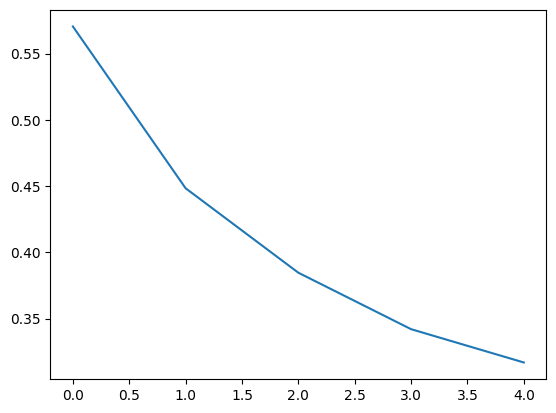

In [100]:
plt.plot(ls)
plt.show()

<font size ='9' > Test </font>

In [101]:
class MyDatasetTest(Dataset):
    def __init__(self, dataPath, trans=None):
        super().__init__()
        self.path = dataPath
        self.files = os.listdir(self.path)
        self.trans = trans

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # our images differ in sizes, we should make them all same size
        im = iio.imread_v2(os.path.join(self.path, self.files[idx]))
        if self.trans:
            im = self.trans(im)
        #im = np.transpose(im,(1,2,0))
        return im


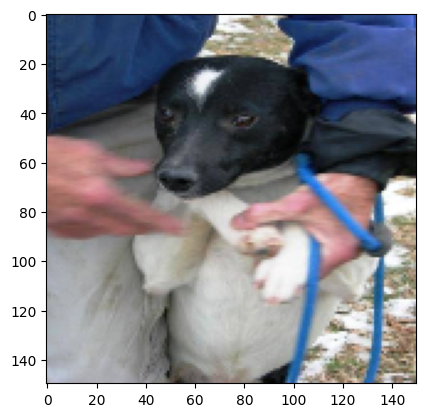

In [102]:
test = MyDatasetTest("C:\\Users\\Ahmed\\Desktop\\CatDogData\\test1", transforms.Compose([transforms.ToTensor(),transforms.Resize((150,150)) ] ) )
plt.imshow(np.transpose(test[0],(1,2,0)), vmin=0.0, vmax=255.0)

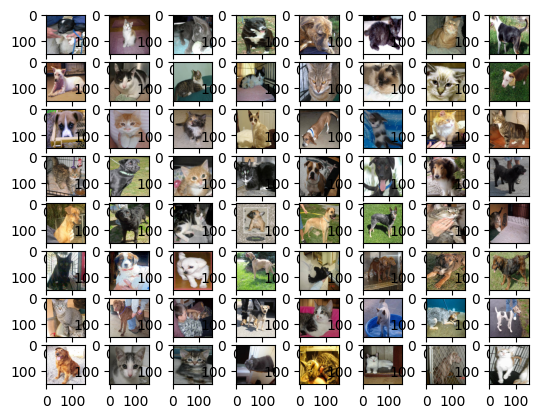

In [109]:
test_loader = DataLoader(test,batch_size = 64)
tl = iter(test_loader)
batch = next (tl)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[i].permute(1, 2, 0), vmin=0.0, vmax=255.0)

In [110]:
pred=[]
for batch in test_loader:
  X = (batch.type(torch.FloatTensor)/255.0)
  # calc y hat , predict values using the neural network u built
  logits = net(X)
  # return max of columns
  labels = torch.argmax(logits, axis =1)
  pred += labels

df = pd.DataFrame(np.array(pred), columns=['Class'])
df

,Class
0,1
1,0
2,0
3,1
4,1
...,...
12495,0
12496,0
12497,1
12498,0


In [111]:
idx = {0:'cat',1:'dog'}
for i in range(len(pred)):
    pred[i] = idx[pred[i].numpy().astype(int).item()]
df = pd.DataFrame(np.array(pred), columns=['Class'])
df

,Class
0,dog
1,cat
2,cat
3,dog
4,dog
...,...
12495,cat
12496,cat
12497,dog
12498,cat


In [112]:
df.index +=1
df

,Class
1,dog
2,cat
3,cat
4,dog
5,dog
...,...
12496,cat
12497,cat
12498,dog
12499,cat


<font size = '8'> Resnet </font>

In [106]:

# USE RESNT
# transfer learning - fine tuning

from torchvision.models import resnet18
net = resnet18(pretrained = True)

net.fc = nn.Linear(in_features = 512 , out_features = 2 , bias = True)

C:\Users\Ahmed\PycharmProjects\CatsDogs\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ahmed\PycharmProjects\CatsDogs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [107]:
num_epochs = 4
lr = 0.01
mm = 0.5

optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
# Learning rate Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.5 , verbose = True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    #set gradients to zero - because pytorch accomulate
    optimizer.zero_grad()
    X, y = (batch[0].type(torch.FloatTensor)/255.0), batch[1]
    # predict
    logits = net(X)
    #loss function
    loss = F.cross_entropy(logits,y)
    #calculating the gradients
    loss.backward()
    #Performs a single optimization step
    optimizer.step()
    # .item() extracts the loss’s value as a Python float.
    total_loss +=loss.item()
  scheduler.step()
  ls.append(total_loss/len(train_loader))
  print(f"[ Epoch {i+1}/4 ] Avg Loss:{ls[i]}")



Adjusting learning rate of group 0 to 1.0000e-02.


C:\Users\Ahmed\PycharmProjects\CatsDogs\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Adjusting learning rate of group 0 to 5.0000e-03.
[ Epoch 1/4 ] Avg Loss:0.10572261947071385
Adjusting learning rate of group 0 to 2.5000e-03.
[ Epoch 2/4 ] Avg Loss:0.03242066786076654
Adjusting learning rate of group 0 to 1.2500e-03.
[ Epoch 3/4 ] Avg Loss:0.02004400529074566
Adjusting learning rate of group 0 to 6.2500e-04.
[ Epoch 4/4 ] Avg Loss:0.012577864816180095


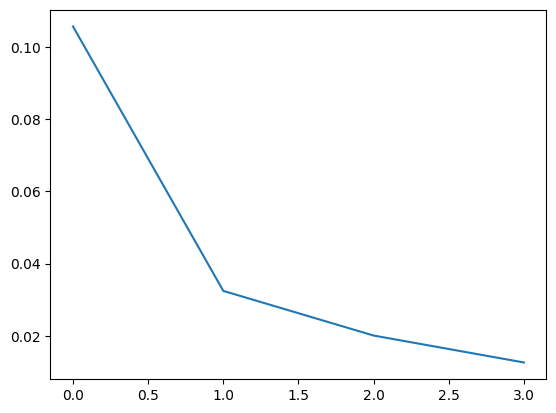

In [108]:
plt.plot(ls)
plt.show()